### 1. Inductive and deductive reasoning

Inductive reasoning means to make generalized conclusions based on specific observations 
 - last winter, it was cold outside, and so was the winter before that. So, this winter, it will be cold outside
 
Deductive reasoning means to make a specific conclusion using general observations
 - SLU is in St. Louis, and St. Louis is in the midwest. So, SLU is in the midwest


### 2. Preprocessing

In [85]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [86]:
column_names = [
    'age', 
    'workclass', 
    'fnlwgt', 
    'education', 
    'education-num', 
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex', 
    'capital-gain', 
    'capital-loss', 
    'hours-per-week', 
    'native-country',
    'outcome'
]
df = pd.read_csv('adult/adult.data', header=None)
df.columns = column_names
df = df.reset_index(drop=True)

df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,outcome
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [87]:
def fill_nan(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Fills empty values 
    '''
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:  # Apply median to numeric columns
            df[col] = df[col].fillna(df[col].median())
        elif df[col].dtype == 'object':  # Apply mode to categorical columns
            df[col] = df[col].fillna(df[col].mode().iloc[0])
    return df

def encode_cat(df: pd.DataFrame, col: str) -> pd.DataFrame:
    '''
    Encodes categorical values into numeric values
    '''
    val_map = {}
    code = 0
    for value in df[col].unique():
        if value not in val_map:
            val_map[value] = code
            code += 1
    df[col] = df[col].map(val_map)
    return df

def clean(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Performs all cleaning operations on df
    '''
   
    fill_nan(df)
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                        'race', 'sex', 'native-country', 'outcome']

    for col in categorical_cols:
        df = encode_cat(df, col)
    return df

df = clean(df)

df.head(10)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,outcome
0,39,0,77516,0,13,0,0,0,0,0,2174,0,40,0,0
1,50,1,83311,0,13,1,1,1,0,0,0,0,13,0,0
2,38,2,215646,1,9,2,2,0,0,0,0,0,40,0,0
3,53,2,234721,2,7,1,2,1,1,0,0,0,40,0,0
4,28,2,338409,0,13,1,3,2,1,1,0,0,40,1,0
5,37,2,284582,3,14,1,1,2,0,1,0,0,40,0,0
6,49,2,160187,4,5,3,4,0,1,1,0,0,16,2,0
7,52,1,209642,1,9,1,1,1,0,0,0,0,45,0,1
8,31,2,45781,3,14,0,3,0,0,1,14084,0,50,0,1
9,42,2,159449,0,13,1,1,1,0,0,5178,0,40,0,1


### 3. Decision Tree

              precision    recall  f1-score   support

           0       0.95      0.77      0.85      7455
           1       0.54      0.86      0.66      2314

    accuracy                           0.79      9769
   macro avg       0.74      0.82      0.76      9769
weighted avg       0.85      0.79      0.81      9769



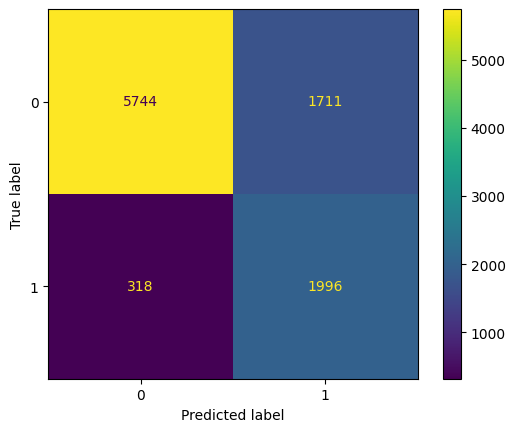

In [88]:
def decision_tree(df: pd.DataFrame=df)->str:
    X = df.drop('outcome',axis=1)
    y = df['outcome']
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.3,
                                                        random_state=42)
    
    model = tree.DecisionTreeClassifier(class_weight='balanced',    
                                        max_depth=10, 
                                        max_features=10,
                                        random_state=42)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

decision_tree()

Tuning: 
 - balanced class weight: adjusts the model to give equal importance to all classes
 - 10 max depth: prevents overfitting by restricting the depth of the tree
 - 10 max features 

### 4. Random Forest

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      7455
           1       0.76      0.52      0.62      2314

    accuracy                           0.85      9769
   macro avg       0.81      0.73      0.76      9769
weighted avg       0.84      0.85      0.84      9769



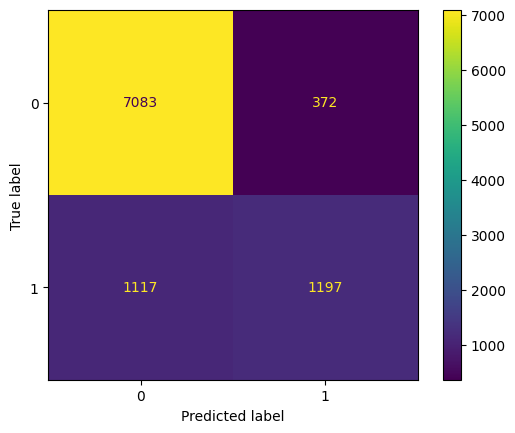

In [89]:
def random_forest(df: pd.DataFrame=df):
    X = df.drop('outcome',axis=1)
    y = df['outcome']
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=42)
    
    rf = RandomForestClassifier(n_estimators=200, 
                                max_depth=5,
                                max_features=10,
                                random_state=42)
    rf = rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    print(classification_report(y_test, y_pred))

    return ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)



random_forest(df)
    

### 5. XGBoost

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.76      0.66      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



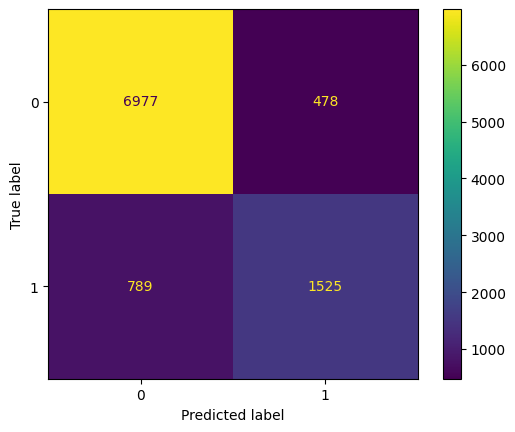

In [90]:
def xgb(df: pd.DataFrame=df):
    X = df.drop('outcome',axis=1)
    y = df['outcome']
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=42)    
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
xgb()